# Deep Learning Small Project
Utilising a pre_trained model created by us to classify covid-19 x-rays pictures

Pretrained model is multiclass_cnn.pt

Members: Tiang Pei Yuan, Lim Yang Zhi, Heng Jing Han

# 0. Imports

In [25]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from sklearn import metrics
from PIL import Image, ImageOps
import os
import copy

# 1. Dataset object

## 1.1 Raw dataset for lung images

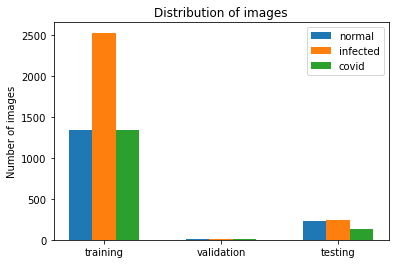

In [26]:
dataset_numbers = {'train_normal': 1341,\
                                'train_infected': 2530,\
                                'train_covid': 1345, \
                                'val_normal': 8,\
                                'val_infected': 8,\
                                'val_covid': 8, \
                                'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}


labels = ['training', 'validation', 'testing']
normal = [dataset_numbers['train_normal'], dataset_numbers['val_normal'], dataset_numbers['test_normal']]
infected = [dataset_numbers['train_infected'], dataset_numbers['val_infected'], dataset_numbers['test_infected']]
covid = [dataset_numbers['train_covid'], dataset_numbers['val_covid'], dataset_numbers['test_covid']]

x = np.arange(len(labels))  
width = 1  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/5, normal, width/5, label='normal')
rects2 = ax.bar(x , infected, width/5, label='infected')
rects3 = ax.bar(x + width/5, covid, width/5, label='covid')


ax.set_ylabel('Number of images')
ax.set_title('Distribution of images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

As seen below, the datasets are much more balanced after the mirroring of the images. This would be important in order to avoid biasedness in the model.

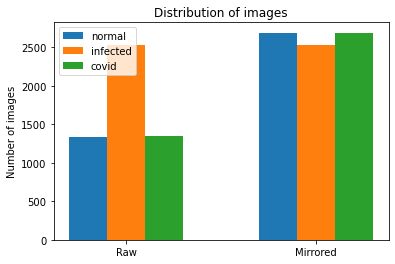

In [27]:
dataset_numbers = {'raw_train_normal': 1341,\
                   'raw_train_infected': 2530,\
                   'raw_train_covid': 1345,
                   'mirrored_train_normal': 2682,\
                   'mirrored_train_infected': 2530,\
                   'mirrored_train_covid': 2690}


labels = ['Raw', 'Mirrored']

normal = [dataset_numbers['raw_train_normal'], dataset_numbers['mirrored_train_normal']]
infected = [dataset_numbers['raw_train_infected'], dataset_numbers['mirrored_train_infected']]
covid = [dataset_numbers['raw_train_covid'], dataset_numbers['mirrored_train_covid']]

x = np.arange(len(labels))  
width = 1  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/5, normal, width/5, label='normal')
rects2 = ax.bar(x , infected, width/5, label='infected')
rects3 = ax.bar(x + width/5, covid, width/5, label='covid')


ax.set_ylabel('Number of images')
ax.set_title('Distribution of images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [28]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 2682,\
                                'train_infected': 2530,\
                                'train_covid': 2690, \
                                'val_normal': 8,\
                                'val_infected': 8,\
                                'val_covid': 8, \
                                'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset_hist_equalization/train/normal/',\
                              'train_infected': './dataset_hist_equalization/train/infected/non-covid/',\
                              'train_covid': './dataset_hist_equalization/train/infected/covid/', \
                              'val_normal': './dataset_hist_equalization/val/normal/',\
                              'val_infected': './dataset_hist_equalization/val/infected/non-covid/',\
                              'val_covid': './dataset_hist_equalization/val/infected/covid/', \
                              'test_normal': './dataset_hist_equalization/test/normal/',\
                              'test_infected': './dataset_hist_equalization/test/infected/non-covid/', \
                              'test_covid': './dataset_hist_equalization/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

## 1.3.1 Train dataset

In [29]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 2682,\
                                'train_infected': 2530,\
                                'train_covid': 2690}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset_hist_equalization/train/normal/',\
                              'train_infected': './dataset_hist_equalization/train/infected/non-covid', \
                              'train_covid': './dataset_hist_equalization/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'"
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [30]:
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 7902 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset_hist_equalization/train/normal/: 2682 images.
 - train_infected, in folder ./dataset_hist_equalization/train/infected/non-covid: 2530 images.
 - train_covid, in folder ./dataset_hist_equalization/train/infected/covid/: 2690 images.



In [31]:
print(len(ld_train))

7902


## 1.3.2 Test dataset

In [32]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset_hist_equalization/test/normal/',\
                              'test_infected': './dataset_hist_equalization/test/infected/non-covid', \
                              'test_covid': './dataset_hist_equalization/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [33]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset_hist_equalization/test/normal/: 234 images.
 - test_infected, in folder ./dataset_hist_equalization/test/infected/non-covid: 242 images.
 - test_covid, in folder ./dataset_hist_equalization/test/infected/covid/: 138 images.



In [34]:
print(len(ld_test))

614


## 1.3.3 Validation dataset

In [35]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected': 8, \
                                'val_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset_hist_equalization/val/normal/',\
                              'val_infected': './dataset_hist_equalization/val/infected/non-covid/', \
                              'val_covid': './dataset_hist_equalization/val/infected/covid'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [36]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset_hist_equalization/val/normal/: 8 images.
 - val_infected, in folder ./dataset_hist_equalization/val/infected/non-covid/: 8 images.
 - val_covid, in folder ./dataset_hist_equalization/val/infected/covid: 8 images.



In [37]:
print(len(ld_val))

24


# 2. Dataloader object

In [38]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 4

# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = 1, shuffle = True)
print(train_loader)
# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [39]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.3137, 0.3176, 0.3216,  ..., 0.3294, 0.3490, 0.3569],
          [0.3216, 0.3216, 0.3255,  ..., 0.3961, 0.3333, 0.2078],
          [0.3059, 0.3098, 0.3176,  ..., 0.3608, 0.2549, 0.1294],
          ...,
          [0.0392, 0.0314, 0.0235,  ..., 0.0078, 0.0000, 0.0039],
          [0.0392, 0.0275, 0.0196,  ..., 0.0078, 0.0000, 0.0039],
          [0.0353, 0.0275, 0.0196,  ..., 0.0078, 0.0000, 0.0039]]]])
tensor([[1., 0., 0.]])


# 3. Neural Network

In [40]:
# https://github.com/pytorch/examples/tree/master/mnist

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import datetime
import numpy as np



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1)
        self.conv6 = nn.Conv2d(128, 128, 3, 1)
        self.conv7 = nn.Conv2d(256, 512, 3, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(100352, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv5(x))
        x = self.dropout1(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1)
#         print("After flatten:", x.shape)
        x = self.fc1(x)
        #print("After fc1:", x.shape)
        x = F.leaky_relu(x)
        #print("After fc2:", x.shape)
        x = self.fc3(x)
        #print("After fc3:", x.shape)
        output = F.log_softmax(x, dim=1)
        #print("Output:", output.shape)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    print('training now...')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        #print(output.long())
        #print(torch.gt(target, 0))
        
        loss = nn.CrossEntropyLoss()
        loss = loss(output, torch.argmax(target, 1))
        
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
                
    #save model at every epoch, avoid restarting training from scratch when there is an unexpected interruption
    model_name = "cnn_epoch" + str(epoch) + ".pt"
    torch.save(model.state_dict(), model_name)

    return loss.item()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            test_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  
    return 100. * correct / len(test_loader.dataset), test_loss


def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            val_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return 100. * correct / len(val_loader.dataset), val_loss


class args:
  batch_size = 16 #'input batch size for training (default: 32)')
  test_batch_size = 1000 #'input batch size for testing (default: 1000)')
  epochs = 20 #'number of epochs to train (default: 14)') # 9~10 is good actually
  lr = 0.75 #'learning rate (default: 1.0)')
  gamma = 0.7 #'Learning rate step gamma (default: 0.7)')
  no_cuda = False #'disables CUDA training')
  dry_run = False #'quickly check a single pass')
  seed = 1 #'random seed (default: 1)')
  log_interval = 1000 #'how many batches to wait before logging training status')
  save_model = True #'For Saving the current Model')
    
        
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")


Loading the pretrained model

In [41]:
pre_trained_model = "./multiclass_cnn.pt"

# 4. Performance on Validation Set

Average performance: 20/24 = 83.33333333333333%


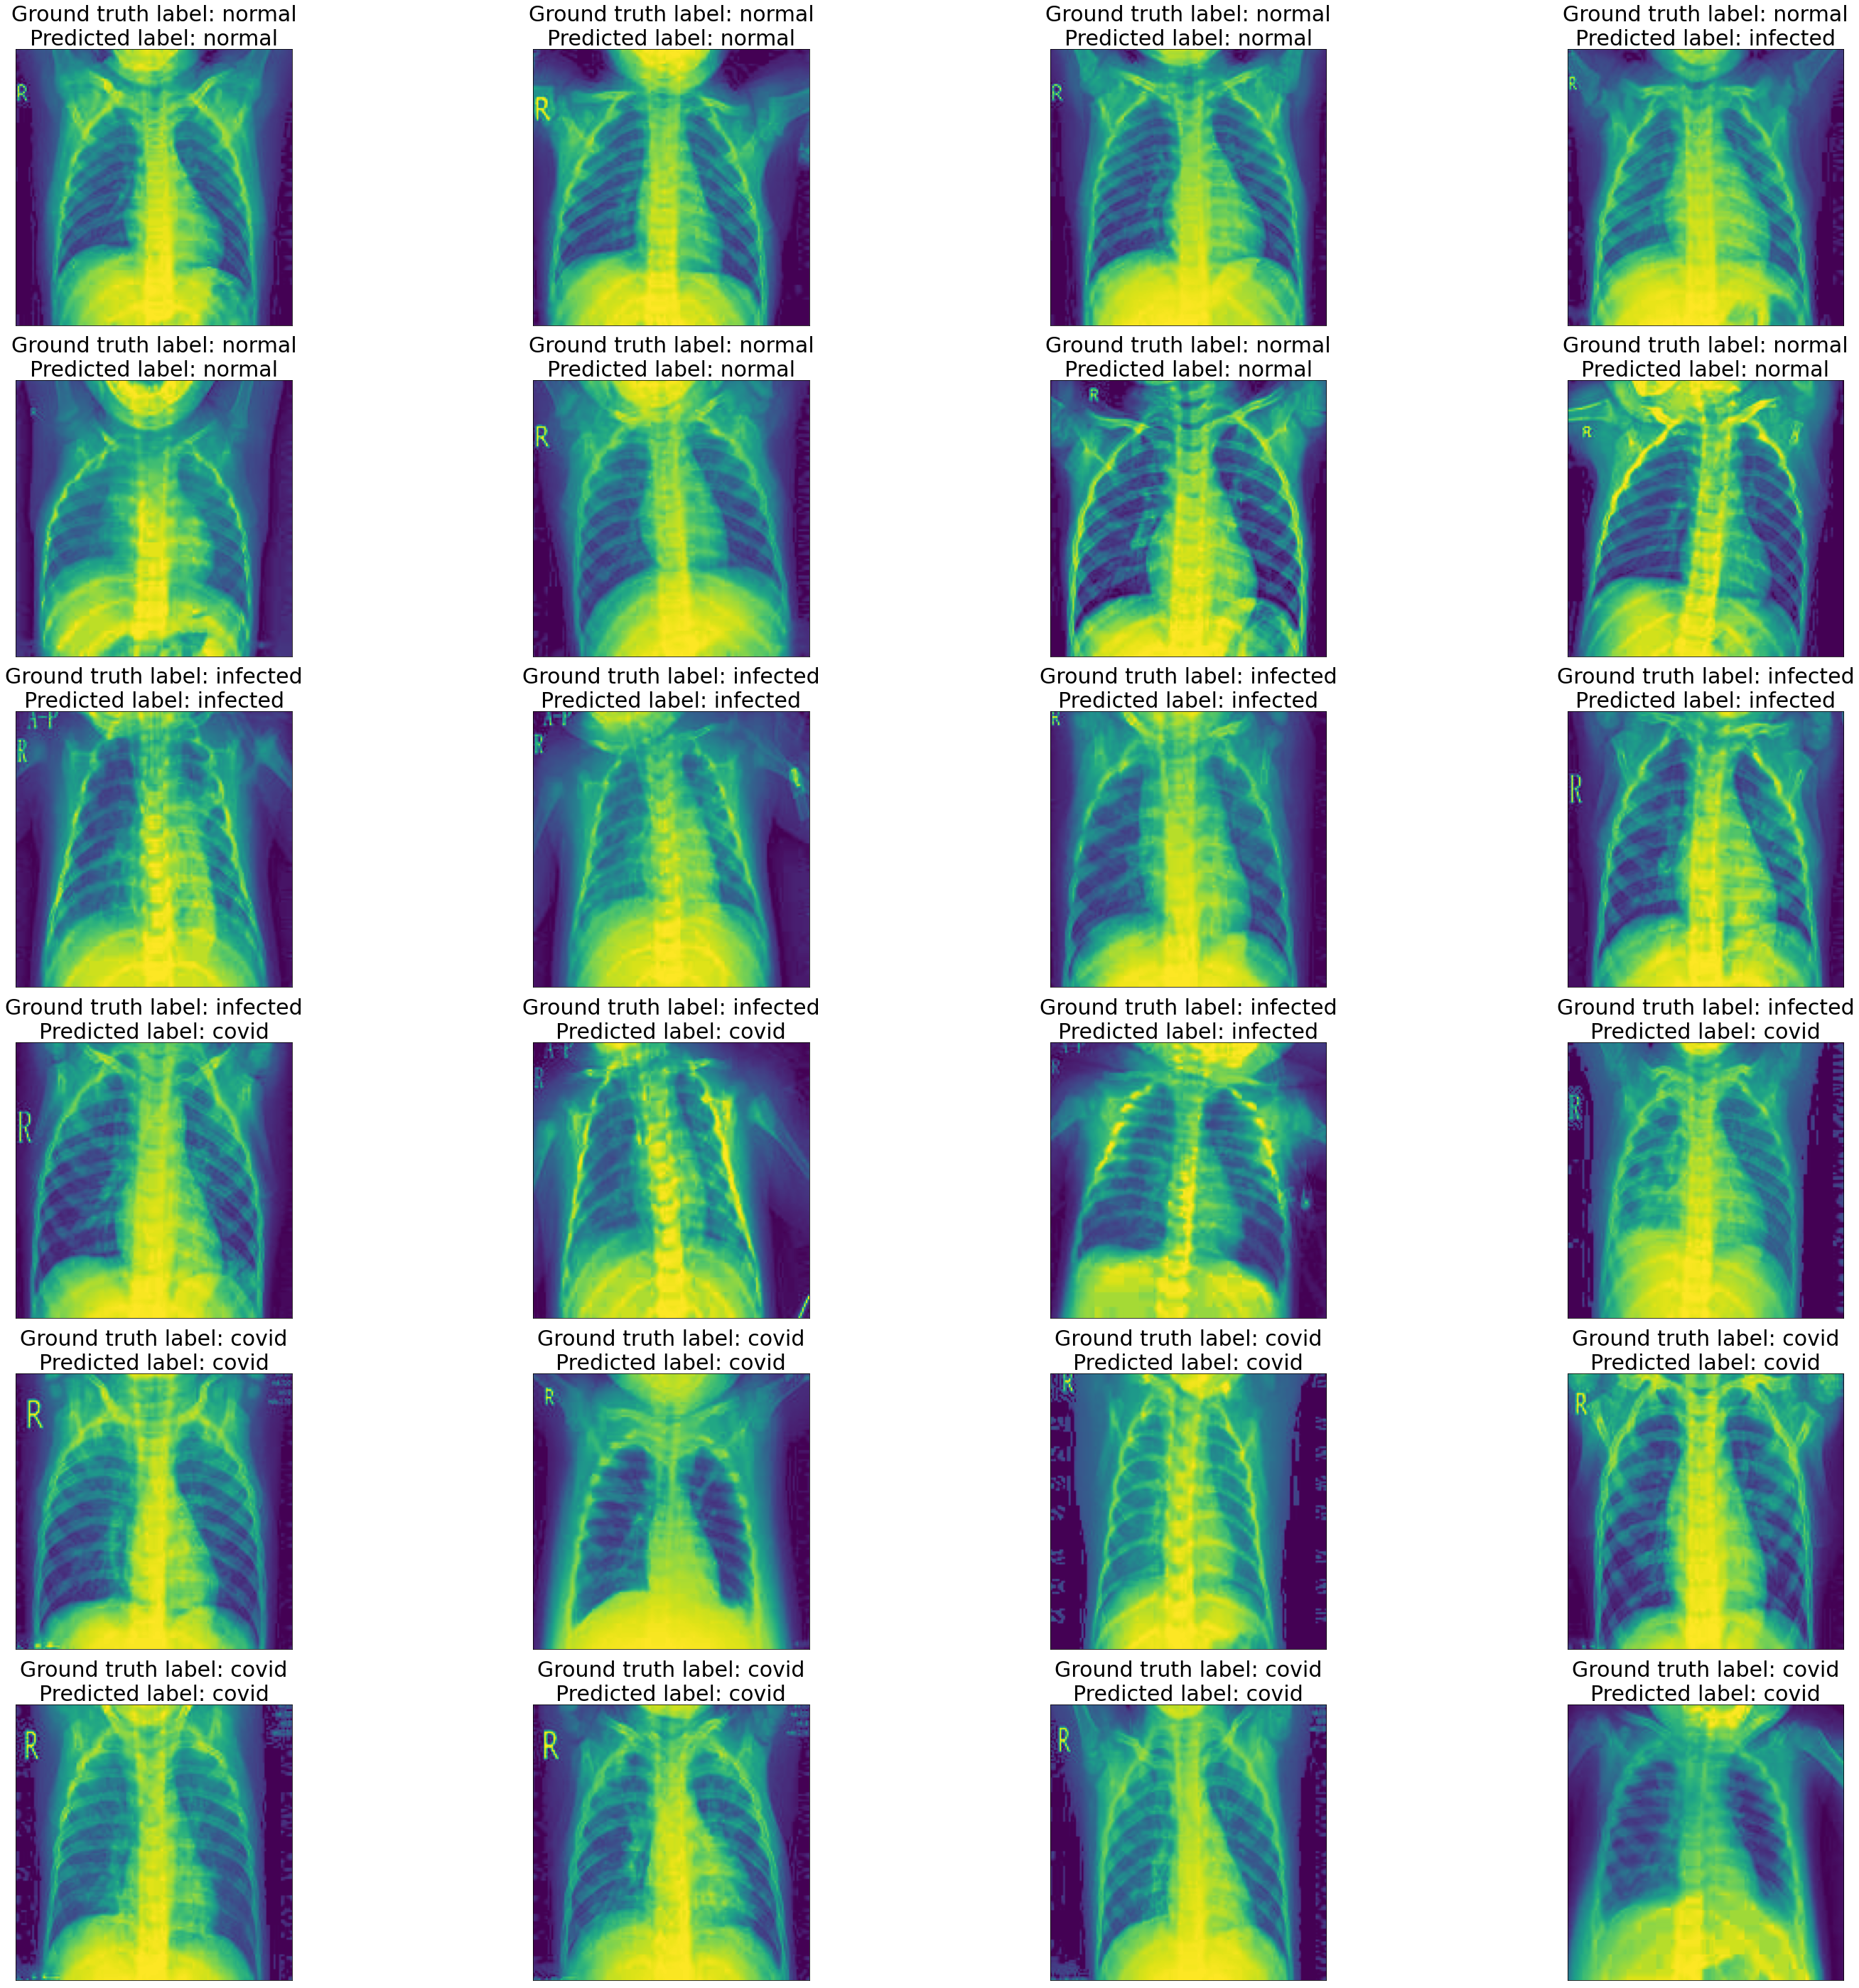

[[8 0 0]
 [3 5 0]
 [0 1 7]]
              precision    recall  f1-score   support

       covid      0.727     1.000     0.842         8
    infected      0.833     0.625     0.714         8
      normal      1.000     0.875     0.933         8

    accuracy                          0.833        24
   macro avg      0.854     0.833     0.830        24
weighted avg      0.854     0.833     0.830        24



In [43]:
model = Net().to(device)
model.load_state_dict(torch.load(pre_trained_model))
classes = {0: 'normal', 1: 'infected', 2: 'covid'}

val_loader = DataLoader(ld_val, batch_size = 1, shuffle = False)
val_pred_list = []
with torch.no_grad():
    for data, target in val_loader: 
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        val_pred_list.append(classes[int(pred)])
    

class_val = ["normal","normal","normal","normal","normal","normal","normal","normal",
             "infected","infected","infected","infected","infected","infected","infected","infected",
             "covid","covid","covid","covid","covid","covid","covid","covid"]
accuracy = 0
for label_index in range(len(val_pred_list)):
    if (val_pred_list[label_index] == class_val[label_index]):
        accuracy += 1
        
print("Average performance: " + str(accuracy) + "/" + str(len(val_pred_list)) + " = " + str(100 * accuracy/len(val_pred_list)) + "%")

f = plt.figure(figsize=(50, 50))
axes = []

for a in range(3 * 8):
    
    classes = class_val[a]

    axes.append(f.add_subplot(6, 4, a+1))
    
    plt.xticks([], [])
    plt.yticks([], [])
    
    subplot_title = ("Ground truth label: " + classes + "\nPredicted label: " + val_pred_list[a])
    axes[-1].set_title(subplot_title, size = 30)
    ld_val.show_img("val", classes, a%8)
    

plt.show()

print(metrics.confusion_matrix(class_val, val_pred_list))
print(metrics.classification_report(class_val, val_pred_list, digits=3))

## 5. Loader Function

In [21]:
def loader_function(model_abs_path):
    '''
    Takes in absolute path of model and checks the accuracy of the model
    '''
    class args:
      batch_size = 16 #'input batch size for training (default: 32)')
      test_batch_size = 1000 #'input batch size for testing (default: 1000)')
      epochs = 20 #'number of epochs to train (default: 14)') # 9~10 is good actually
      lr = 0.8 #'learning rate (default: 1.0)')
      gamma = 0.7 #'Learning rate step gamma (default: 0.7)')
      no_cuda = False #'disables CUDA training')
      dry_run = False #'quickly check a single pass')
      seed = 1 #'random seed (default: 1)')
      log_interval = 1000 #'how many batches to wait before logging training status')
      save_model = True #'For Saving the current Model')

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #model_path = './hist_mirrored_cnn/cnn_epoch8.pt'

    model = Net()
    model.load_state_dict(torch.load(model_abs_path))
    model.to(device)

    bs_val = 4
    # Dataloader from dataset (test and val)
    test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
    val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

    val_loss_list = []
    val_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    test_accuracy, test_loss = test(model, device, test_loader)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    val_accuracy, val_loss = validate(model, device, val_loader)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    
loader_function(pre_trained_model)


Test set: Average loss: 0.5828, Accuracy: 378/614 (62%)


Validation set: Average loss: 0.1472, Accuracy: 21/24 (88%)

